[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Shape: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


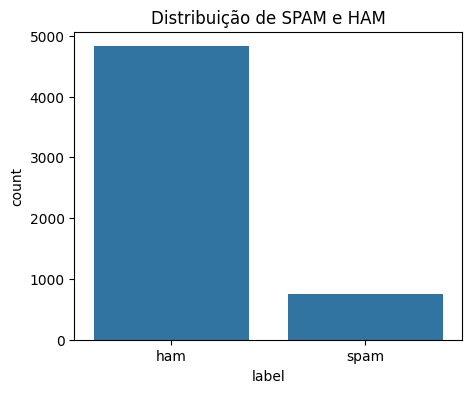

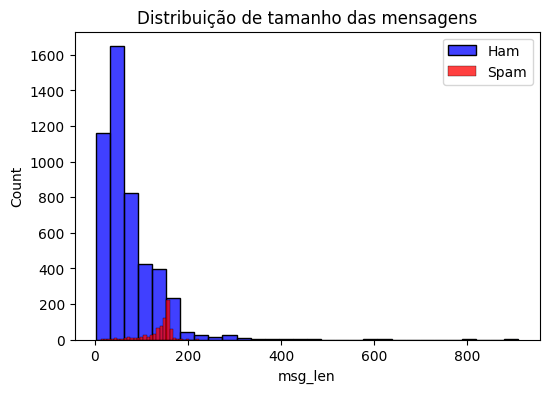

--2025-10-07 23:30:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-07 23:30:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-07 23:30:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.8438 - loss: 0.4315 - val_accuracy: 0.9428 - val_loss: 0.1618
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9493 - loss: 0.1504 - val_accuracy: 0.9529 - val_loss: 0.1337
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9603 - loss: 0.1200 - val_accuracy: 0.9608 - val_loss: 0.1208
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9650 - loss: 0.1076 - val_accuracy: 0.9619 - val_loss: 0.1079
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9680 - loss: 0.1025 - val_accuracy: 0.9619 - val_loss: 0.0996
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Acurácia LSTM: 0.9623318385650225


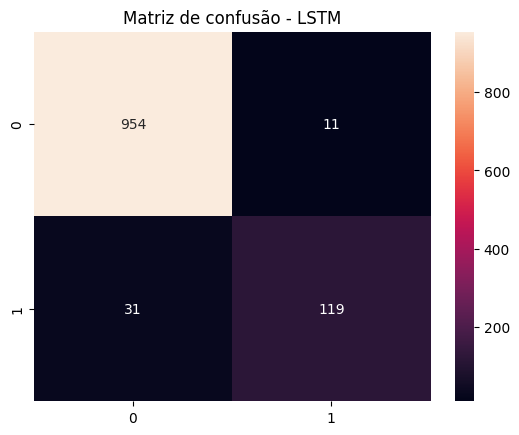

Acurácia MLP TF-IDF: 0.97847533632287


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


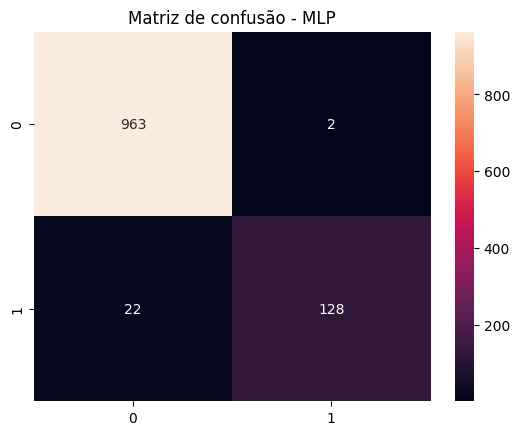

\nComparação de acurácia:\nLSTM (GloVe): 0.962\nMLP (TF-IDF): 0.978


In [4]:
# ===============================================
# 🧠 Detecção de SPAM com LSTM e vetorização GloVe
# ===============================================

# --- Instalação de dependências ---
!pip -q install nltk tensorflow scikit-learn matplotlib seaborn

# --- Importações ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import nltk
nltk.download('stopwords')

# --- Carregamento do Dataset ---
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1','v2']]
df.columns = ['label','message']
print(df.head())
print(f"Shape: {df.shape}")
print(df['label'].value_counts())

# --- Limpeza e pré-processamento ---
stopwords_set = set(ENGLISH_STOP_WORDS)
def preprocess(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = [w for w in text.split() if w not in stopwords_set]
    return ' '.join(tokens)
df['clean_text'] = df['message'].apply(preprocess)

# --- Análise exploratória ---
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df)
plt.title('Distribuição de SPAM e HAM')
plt.show()

df['msg_len'] = df['message'].apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df[df['label']=='ham']['msg_len'], color='blue', label='Ham', bins=30)
sns.histplot(df[df['label']=='spam']['msg_len'], color='red', label='Spam', bins=30)
plt.legend()
plt.title('Distribuição de tamanho das mensagens')
plt.show()

# --- Separação treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# --- Vetorização GloVe ---
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove
embedding_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        embedding_index[values[0]] = np.asarray(values[1:], dtype='float32')
print(f"Total de vetores GloVe: {len(embedding_index)}")

# --- Tokenização ---
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

# --- Modelo LSTM ---
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

history = model.fit(X_train_seq, y_train_enc, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# --- Avaliação ---
y_pred = (model.predict(X_test_seq) > 0.5).astype(int)
acc_lstm = accuracy_score(y_test_enc, y_pred)
cm_lstm = confusion_matrix(y_test_enc, y_pred)
print(f"Acurácia LSTM: {acc_lstm}")
sns.heatmap(cm_lstm, annot=True, fmt='d')
plt.title('Matriz de confusão - LSTM')
plt.show()

# --- Modelo baseline (MLP + TF-IDF) ---
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=10)
mlp.fit(X_train_tfidf, y_train_enc)
y_pred_mlp = mlp.predict(X_test_tfidf)
acc_mlp = accuracy_score(y_test_enc, y_pred_mlp)
cm_mlp = confusion_matrix(y_test_enc, y_pred_mlp)
print(f"Acurácia MLP TF-IDF: {acc_mlp}")
sns.heatmap(cm_mlp, annot=True, fmt='d')
plt.title('Matriz de confusão - MLP')
plt.show()

# --- Comparação final ---
print(f"\\nComparação de acurácia:\\nLSTM (GloVe): {acc_lstm:.3f}\\nMLP (TF-IDF): {acc_mlp:.3f}")
